# 日経平均株価 日足

In [15]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

symbol = '^N225'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-06-13 00:00:00+09:00,39182.058594,39252.441406,38689.789062,38720.468750,115900000,0.0,0.0
2024-06-14 00:00:00+09:00,38587.570312,39025.699219,38554.750000,38814.558594,157100000,0.0,0.0
2024-06-17 00:00:00+09:00,38440.980469,38442.699219,37950.199219,38102.441406,107500000,0.0,0.0
2024-06-18 00:00:00+09:00,38433.480469,38519.019531,38332.890625,38482.109375,97100000,0.0,0.0
2024-06-19 00:00:00+09:00,38653.910156,38797.968750,38453.410156,38570.761719,93600000,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-09 00:00:00+09:00,39332.550781,39332.550781,38972.781250,39160.500000,113100000,0.0,0.0
2024-12-10 00:00:00+09:00,39375.488281,39465.140625,39171.691406,39367.578125,110300000,0.0,0.0
2024-12-11 00:00:00+09:00,39357.769531,39401.929688,39112.800781,39372.230469,105800000,0.0,0.0


## パラボリック SAR

In [16]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 日足チャートとパラボリック SAR

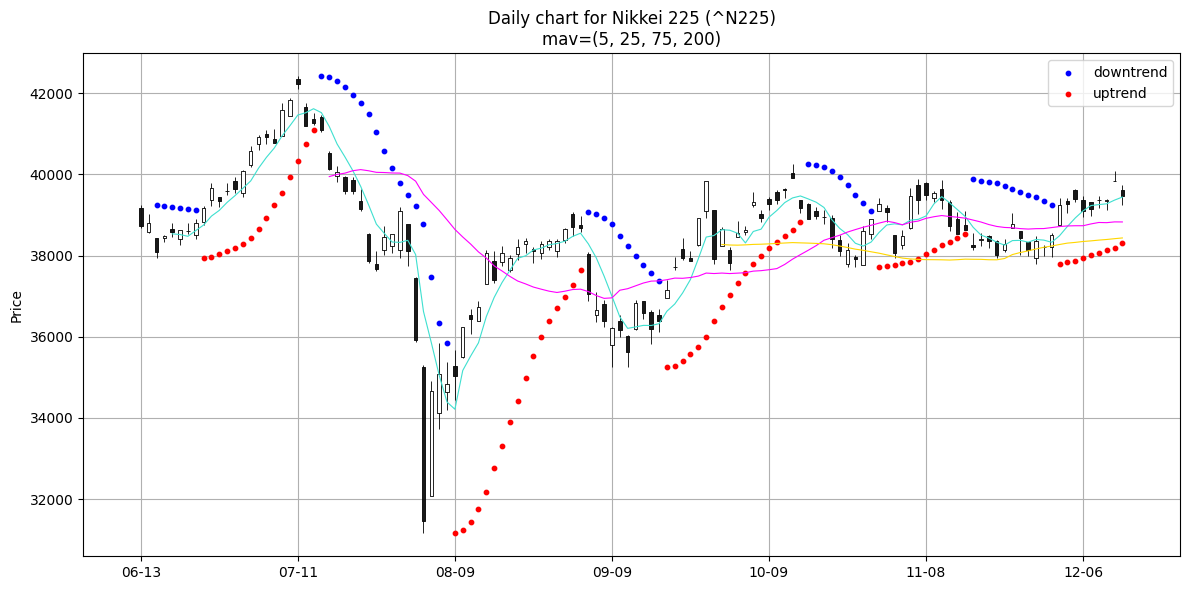

In [17]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=10,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=10,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75, 200),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75, 200)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75, 200)' % symbol)

ax.grid()

plt.tight_layout()
plt.savefig('daily_chart_n225.png')
plt.show()

In [12]:
df.tail(2)['Close']

Date
2024-12-12 00:00:00+09:00    39849.140625
2024-12-13 00:00:00+09:00    39470.441406
Name: Close, dtype: float64

In [13]:
df.tail(2)['Close'].diff()

Date
2024-12-12 00:00:00+09:00           NaN
2024-12-13 00:00:00+09:00   -378.699219
Name: Close, dtype: float64

In [14]:
df['Close'].rolling(25).mean()

Date
2024-06-13 00:00:00+09:00             NaN
2024-06-14 00:00:00+09:00             NaN
2024-06-17 00:00:00+09:00             NaN
2024-06-18 00:00:00+09:00             NaN
2024-06-19 00:00:00+09:00             NaN
                                 ...     
2024-12-09 00:00:00+09:00    38781.776719
2024-12-10 00:00:00+09:00    38817.483906
2024-12-11 00:00:00+09:00    38813.146250
2024-12-12 00:00:00+09:00    38831.855469
2024-12-13 00:00:00+09:00    38830.658281
Name: Close, Length: 126, dtype: float64

In [7]:
df['Close'].rolling(75).mean()

Date
2023-12-13 00:00:00+09:00             NaN
2023-12-14 00:00:00+09:00             NaN
2023-12-15 00:00:00+09:00             NaN
2023-12-18 00:00:00+09:00             NaN
2023-12-19 00:00:00+09:00             NaN
                                 ...     
2024-12-09 00:00:00+09:00    38364.145990
2024-12-10 00:00:00+09:00    38383.023021
2024-12-11 00:00:00+09:00    38398.505937
2024-12-12 00:00:00+09:00    38418.304219
2024-12-13 00:00:00+09:00    38436.440521
Name: Close, Length: 247, dtype: float64

In [8]:
df['Close'].rolling(200).mean()

Date
2023-12-13 00:00:00+09:00             NaN
2023-12-14 00:00:00+09:00             NaN
2023-12-15 00:00:00+09:00             NaN
2023-12-18 00:00:00+09:00             NaN
2023-12-19 00:00:00+09:00             NaN
                                 ...     
2024-12-09 00:00:00+09:00    38680.948525
2024-12-10 00:00:00+09:00    38685.434521
2024-12-11 00:00:00+09:00    38690.477627
2024-12-12 00:00:00+09:00    38698.412529
2024-12-13 00:00:00+09:00    38700.271338
Name: Close, Length: 247, dtype: float64